# ARIMA

In [1]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np

## Load data

In [2]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1571,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False
1572,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False
1573,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False
1574,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False


## ARIMA

In [3]:
# Count missing and outlier cases
print('Missing cases:', df['Revenue Losses'].isnull().sum())
# Mark missing cases
df['Missing'] = df['Revenue Losses'].isnull()
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 129
Outlier cases: 119


In [4]:
# Set missing and outlier cases to the mean of the data - we will use exogenous regressors to de facto remove them later
df['Revenue Losses'] = df['Revenue Losses'].fillna(df['Revenue Losses'].mean())
df['Revenue Losses'] = df['Revenue Losses'].mask(df['Outlier'], df['Revenue Losses'].mean())

In [5]:
df = df[['Date', 'Revenue Losses', 'Train', 'Missing', 'Outlier']]
df

,Date,Revenue Losses,Train,Missing,Outlier
0,2020-10-25,221250.0,True,False,False
1,2020-10-26,233125.0,True,False,False
2,2020-10-27,266875.0,True,False,False
3,2020-10-28,244375.0,True,False,False
4,2020-10-29,233750.0,True,False,False
...,...,...,...,...,...
1571,2025-02-12,798125.0,False,False,False
1572,2025-02-13,743125.0,False,False,False
1573,2025-02-14,667500.0,False,False,False
1574,2025-02-15,691875.0,False,False,False


In [6]:
# Add a column of indicators for each row to indicate whether the row is an outlier
outlier_cols = []
for i in range(len(df)):
    if df.loc[i, 'Outlier'] == 1:
        df['Outlier_' + str(df['Revenue Losses'][i])] = [1 if j == i else 0 for j in range(len(df))]
        outlier_cols.append('Outlier_' + str(df['Revenue Losses'][i]))
df

C:\Users\ijyli\AppData\Local\Temp\ipykernel_13248\380620750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outlier_' + str(df['Revenue Losses'][i])] = [1 if j == i else 0 for j in range(len(df))]


,Date,Revenue Losses,Train,Missing,Outlier,Outlier_908899.8790601244
0,2020-10-25,221250.0,True,False,False,0
1,2020-10-26,233125.0,True,False,False,0
2,2020-10-27,266875.0,True,False,False,0
3,2020-10-28,244375.0,True,False,False,0
4,2020-10-29,233750.0,True,False,False,0
...,...,...,...,...,...,...
1571,2025-02-12,798125.0,False,False,False,0
1572,2025-02-13,743125.0,False,False,False,0
1573,2025-02-14,667500.0,False,False,False,0
1574,2025-02-15,691875.0,False,False,False,0


In [7]:
# Add a column of indicators for each row to indicate whether the row is missing
missing_cols = []
for i in range(len(df)):
    if df.loc[i, 'Missing'] == 1:
        df['Missing_' + str(df['Revenue Losses'][i])] = [1 if j == i else 0 for j in range(len(df))]
        outlier_cols.append('Missing_' + str(df['Revenue Losses'][i]))
df

C:\Users\ijyli\AppData\Local\Temp\ipykernel_13248\9150737.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Missing_' + str(df['Revenue Losses'][i])] = [1 if j == i else 0 for j in range(len(df))]


,Date,Revenue Losses,Train,Missing,Outlier,Outlier_908899.8790601244,Missing_908899.8790601244
0,2020-10-25,221250.0,True,False,False,0,0
1,2020-10-26,233125.0,True,False,False,0,0
2,2020-10-27,266875.0,True,False,False,0,0
3,2020-10-28,244375.0,True,False,False,0,0
4,2020-10-29,233750.0,True,False,False,0,0
...,...,...,...,...,...,...,...
1571,2025-02-12,798125.0,False,False,False,0,0
1572,2025-02-13,743125.0,False,False,False,0,0
1573,2025-02-14,667500.0,False,False,False,0,0
1574,2025-02-15,691875.0,False,False,False,0,0


In [8]:
# Train/test split
train_df = df.query('Train == 1').reset_index(drop=True)
test_df = df.query('Train == 0').reset_index(drop=True)
print(len(train_df), len(test_df))

1546 30


In [9]:
from pmdarima import auto_arima

# Fit the ARIMA model using pmdarima's auto_arima
n = len(train_df)
model = auto_arima(train_df['Revenue Losses'], X=train_df[outlier_cols + missing_cols], seasonal=True, suppress_warnings=True)
model.fit(train_df['Revenue Losses'], X=train_df[outlier_cols + missing_cols])

# Forecast future values with the fitted model
forecast_steps =30

# Get the forecast for the future steps with exogenous variables
forecast_df = test_df[outlier_cols + missing_cols]
forecast_values, conf_int = model.predict(n_periods=forecast_steps, X=forecast_df, return_conf_int=True)
# Create a Pandas Series for the forecast and confidence intervals
forecast_series = pd.Series(forecast_values, index=test_df.index)
lower_series = pd.Series(conf_int[:, 0], index=test_df.index)
upper_series = pd.Series(conf_int[:, 1], index=test_df.index)

# Retrieve the index for forecasting
forecast_start = str(list(df.index)[-1] + pd.DateOffset(1)).split(' ')[0]
forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps)

ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
# Check residuals
def plot_arima_residuals(fit, lags=10, bins=20):
    """
    Generates and displays a suite of residual plots for ARIMA models 
    fitted using pmdarima's auto_arima.

    Args:
        fit: The fitted ARIMA model object from pmdarima's auto_arima.
        lags: Number of lags to plot in the ACF.
        bins: Number of bins for the histogram.
    """

    residuals = fit.resid()  # Use fit.resid() for pmdarima
    fitted_values = fit.fittedvalues() # Use fit.fittedvalues()

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    # 1. Time Series Plot of Residuals
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Time')  # More general x-axis label
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True)

    # 2. Histogram of Residuals
    axes[0, 1].hist(residuals, bins=bins)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')

    # 4. ACF Plot
    plot_acf(residuals, lags=lags, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelation Function (ACF)')

    # 5. Residuals vs. Fitted Values
    axes[2, 0].scatter(fitted_values, residuals)
    axes[2, 0].set_title('Residuals vs. Fitted Values')
    axes[2, 0].set_xlabel('Fitted Values')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].grid(True)

    fig.delaxes(axes[2, 1])  # Remove the empty subplot

    plt.tight_layout()
    plt.show()

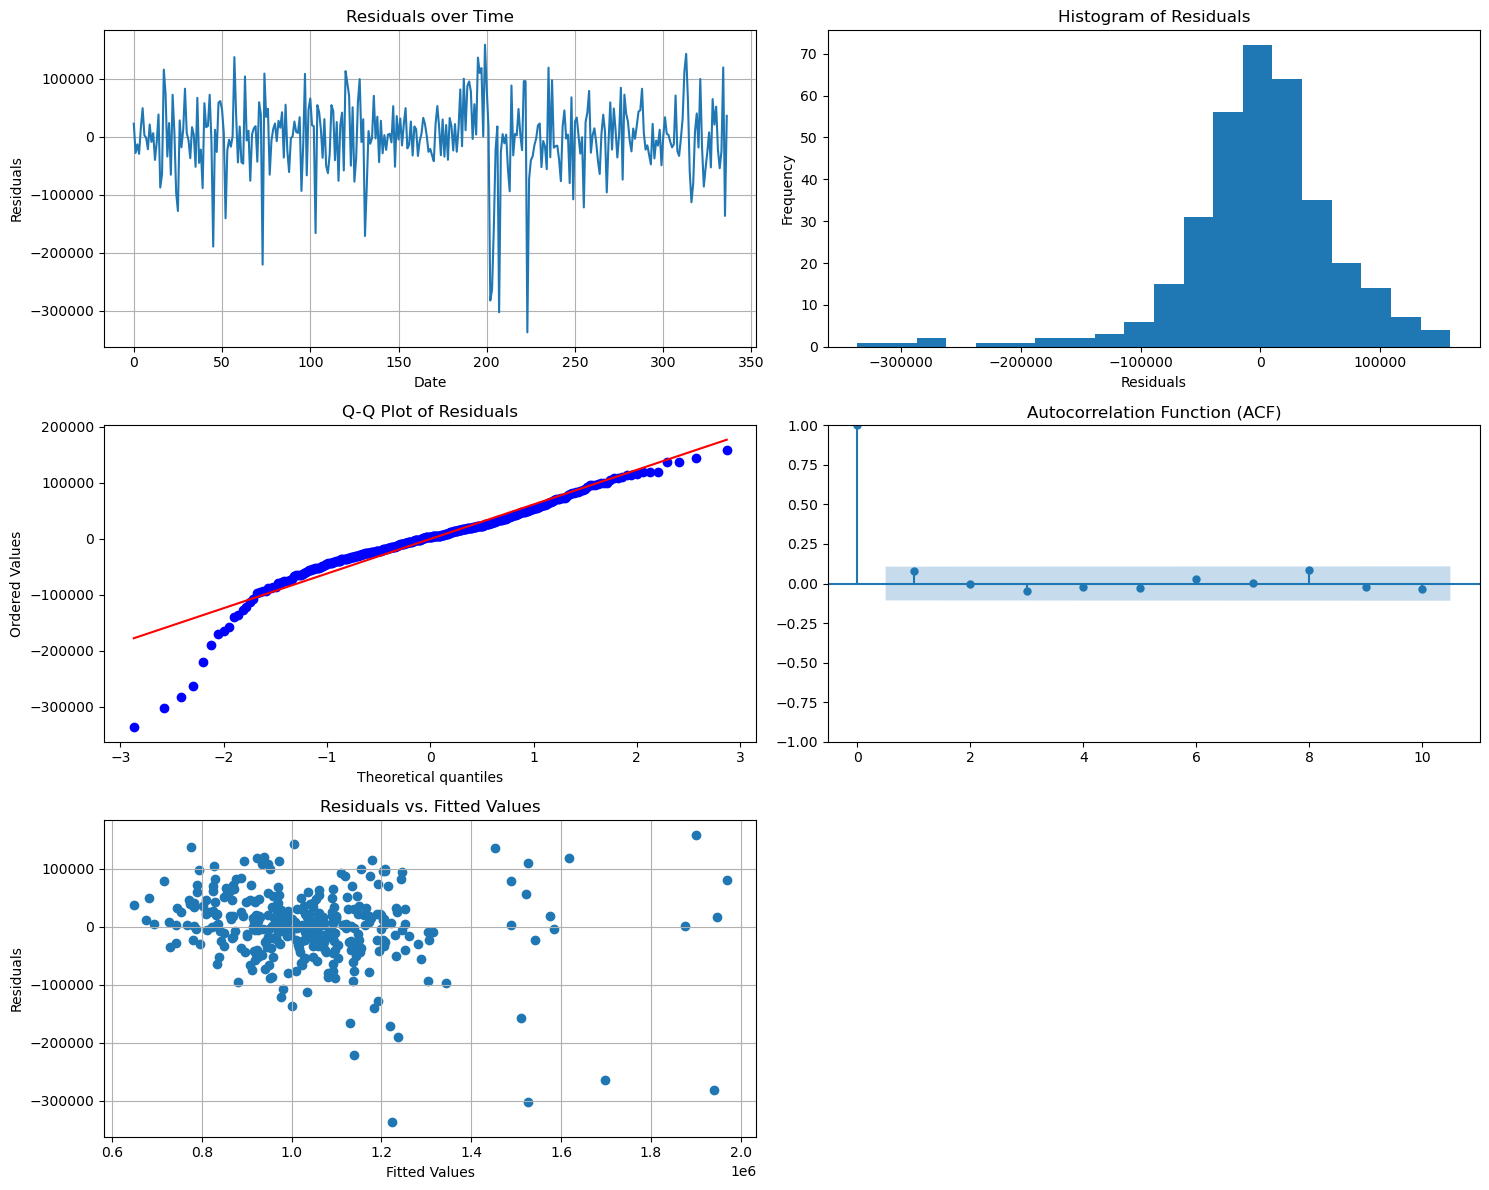

In [ ]:
plot_arima_residuals(model)

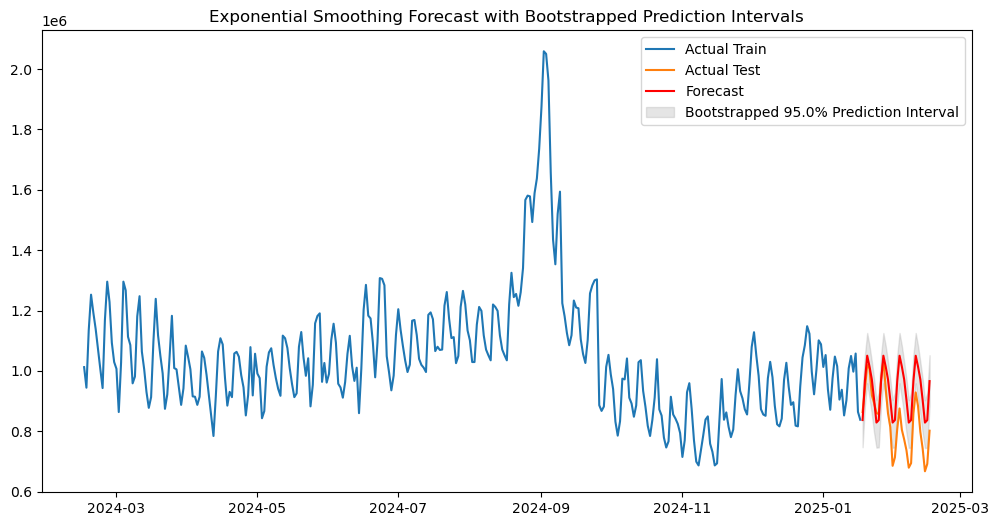

In [ ]:
# Plot intervals
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Revenue Losses'], label='Actual Train')
plt.plot(test_df['Date'], test_df['Revenue Losses'], label='Actual Test')
plt.plot(test_df['Date'], forecast_values, label='Forecast', color='red')  # Original forecast

plt.fill_between(test_df['Date'], lower_series, upper_series, color='gray', alpha=0.2, label=f'95% Prediction Interval')

plt.title('ARIMA Prediction Intervals')
plt.legend()
plt.show()

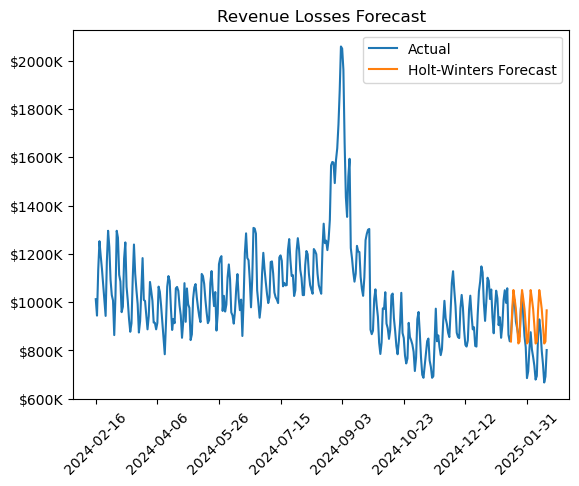

MAE: 104248.90875900308


In [ ]:
plt.plot(df['Revenue Losses'], label="Actual")
plt.plot(forecast_values, label="Holt-Winters Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE, RMSE on test set
mae = mean_absolute_error(test_df['Revenue Losses'], forecast_values)
rmse = root_mean_squared_error(test_df['Revenue Losses'], forecast_values)
print('MAE:', mae)
print('RMSE:', rmse)
# Also compute MAPE for reporting
mape = np.mean(np.abs((test_df['y'] - forecast['yhat'][-len(test_df):]) / test_df['y'])) * 100
print('MAPE:', mape)

In [ ]:
# 7-day seasonal naive forecast for comparison
last_7 = list(train_df['y'][-7:])
seasonal_naive_forecast = [last_7[i % 7] for i in range(len(test_df))]
# Set index of dates to be that of test_df
seasonal_naive_forecast_df = pd.DataFrame(seasonal_naive_forecast, index=test_df.index, columns=['y'])

In [ ]:
# PLot with seasonal naive forecast
plt.plot(test_df['Revenue Losses'], label="Actual")
plt.plot(forecast_values, label="ARIMA Forecast")
# Seasonal naive forecast
plt.plot(seasonal_naive_forecast_df['y'], label="Seasonal Naive Forecast")
# Add prophet prediction intervals
plt.fill_between(test_df.index, lower_series, upper_series, color='gray', alpha=0.2, label='95% Prediction Interval')
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['ds'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# MAE, RMSE, MAPE for seasonal naive forecast
mae = mean_absolute_error(test_df['y'], seasonal_naive_forecast)
rmse = root_mean_squared_error(test_df['y'], seasonal_naive_forecast)
print('Seasonal Naive MAE:', mae)
print('Seasonal Naive RMSE:', rmse)
mape = np.mean(np.abs((test_df['y'] - seasonal_naive_forecast) / test_df['y'])) * 100
print('Seasonal Naive MAPE:', mape)

NOTES